# Explore embeddings

Load and explore embeddings from different methods


Install required packages:
```
uv add pyarrow nbformat plotly
```

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

Load embeddings

In [2]:
from pathlib import Path

basepath = Path("../data/embeddings/")

movie_embeddings_dfs = {
    filepath.name.split(".")[0]: pl.read_parquet(filepath)
    for filepath in basepath.glob("**/*")
}

if 0:
    movie_embeddings_dfs = pl.concat(
        [
            pl.read_parquet(filepath).with_columns(
                name=pl.lit(filepath.name.split(".")[0])
            )
            for filepath in basepath.glob("**/*")
        ],
        how="vertical_relaxed",
    )

movie_embeddings_dfs

{'tf_idf': shape: (62_423, 6)
 ┌─────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
 │ movieId ┆ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ column_4  │
 │ ---     ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ i64     ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞═════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 1       ┆ -0.293057 ┆ 0.049286  ┆ -0.015613 ┆ 0.062947  ┆ 0.01893   │
 │ 2       ┆ -0.174829 ┆ -0.175218 ┆ -0.019354 ┆ 0.079596  ┆ 0.083039  │
 │ 3       ┆ -0.331659 ┆ 0.486516  ┆ -0.002736 ┆ -0.05339  ┆ 0.64031   │
 │ 4       ┆ 0.082251  ┆ 0.526241  ┆ 0.009123  ┆ -0.099687 ┆ 0.509489  │
 │ 5       ┆ -0.507267 ┆ 0.68719   ┆ 0.005605  ┆ -0.049001 ┆ -0.204164 │
 │ …       ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
 │ 209157  ┆ 0.766441  ┆ 0.090956  ┆ 0.021121  ┆ -0.110573 ┆ -0.130891 │
 │ 209159  ┆ -0.272379 ┆ -0.423134 ┆ 0.783925  ┆ -0.317768 ┆ -0.047578 │
 │ 209163  ┆ 0.144679

In [3]:
ratings_df = utilities.load_ratings()
movies_df = utilities.load_movies()
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
top_movies_df = movies_df.join(top_movie_ids, on="movieId")
labels = top_movies_df["title"].to_list()
top_movies_df

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Mystery|Sci-Fi|Thriller"""
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller"""
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller"""
110,"""Braveheart (1995)""","""Action|Drama|War"""
…,…,…
4993,"""Lord of the Rings: The Fellows…","""Adventure|Fantasy"""
5952,"""Lord of the Rings: The Two Tow…","""Adventure|Fantasy"""
7153,"""Lord of the Rings: The Return …","""Action|Adventure|Drama|Fantasy"""


### Cosine similarity

Use cosine similarity on embedding pairs to find similar titles.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity


def get_embedding_vectors(movie_embeddings_df: pl.DataFrame) -> np.array:
    # limit to top movies only
    return (
        top_movies_df["movieId", "title"]
        .join(movie_embeddings_df, on="movieId", how="left")
        .drop(["movieId", "title"])
        .to_numpy()
    )


def get_cosine_similarities(movie_embeddings_df: pl.DataFrame) -> np.array:
    embedding_values = get_embedding_vectors(movie_embeddings_df)

    similarity_matrix = cosine_similarity(embedding_values)
    # limit to lower triangle only
    similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=0)] = np.nan

    return similarity_matrix

The strongest and weakest similarities:

In [5]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)
    utilities.get_extreme_similarities(
        similarity_matrix=similarity_matrix, labels=labels, top_n=10
    )
    print()

tf_idf
Most similar:
1.00 - Matrix, The (1999), Terminator, The (1984)
1.00 - Indiana Jones and the Last Crusade (1989), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
1.00 - Star Wars: Episode VI - Return of the Jedi (1983), Star Wars: Episode V - The Empire Strikes Back (1980)
1.00 - Star Wars: Episode VI - Return of the Jedi (1983), Star Wars: Episode IV - A New Hope (1977)
1.00 - American Beauty (1999), Good Will Hunting (1997)
1.00 - American Beauty (1999), Titanic (1997)
1.00 - Star Wars: Episode V - The Empire Strikes Back (1980), Star Wars: Episode IV - A New Hope (1977)
1.00 - Memento (2000), Seven (a.k.a. Se7en) (1995)
1.00 - Independence Day (a.k.a. ID4) (1996), Jurassic Park (1993)
1.00 - Titanic (1997), Good Will Hunting (1997)

Least similar:
-0.99 - Aladdin (1992), Schindler's List (1993)
-0.99 - Schindler's List (1993), Toy Story (1995)
-0.99 - Monty Python and the Holy Grail (1975), Schindler's List (1993)
-0.98 - Ace Ventura: Pet Detect

Plotting similarities for all 50x50 pairs:

tf_idf


/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/unfinished-movie_similarity/utilities.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/unfinished-movie_similarity/utilities.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


nn


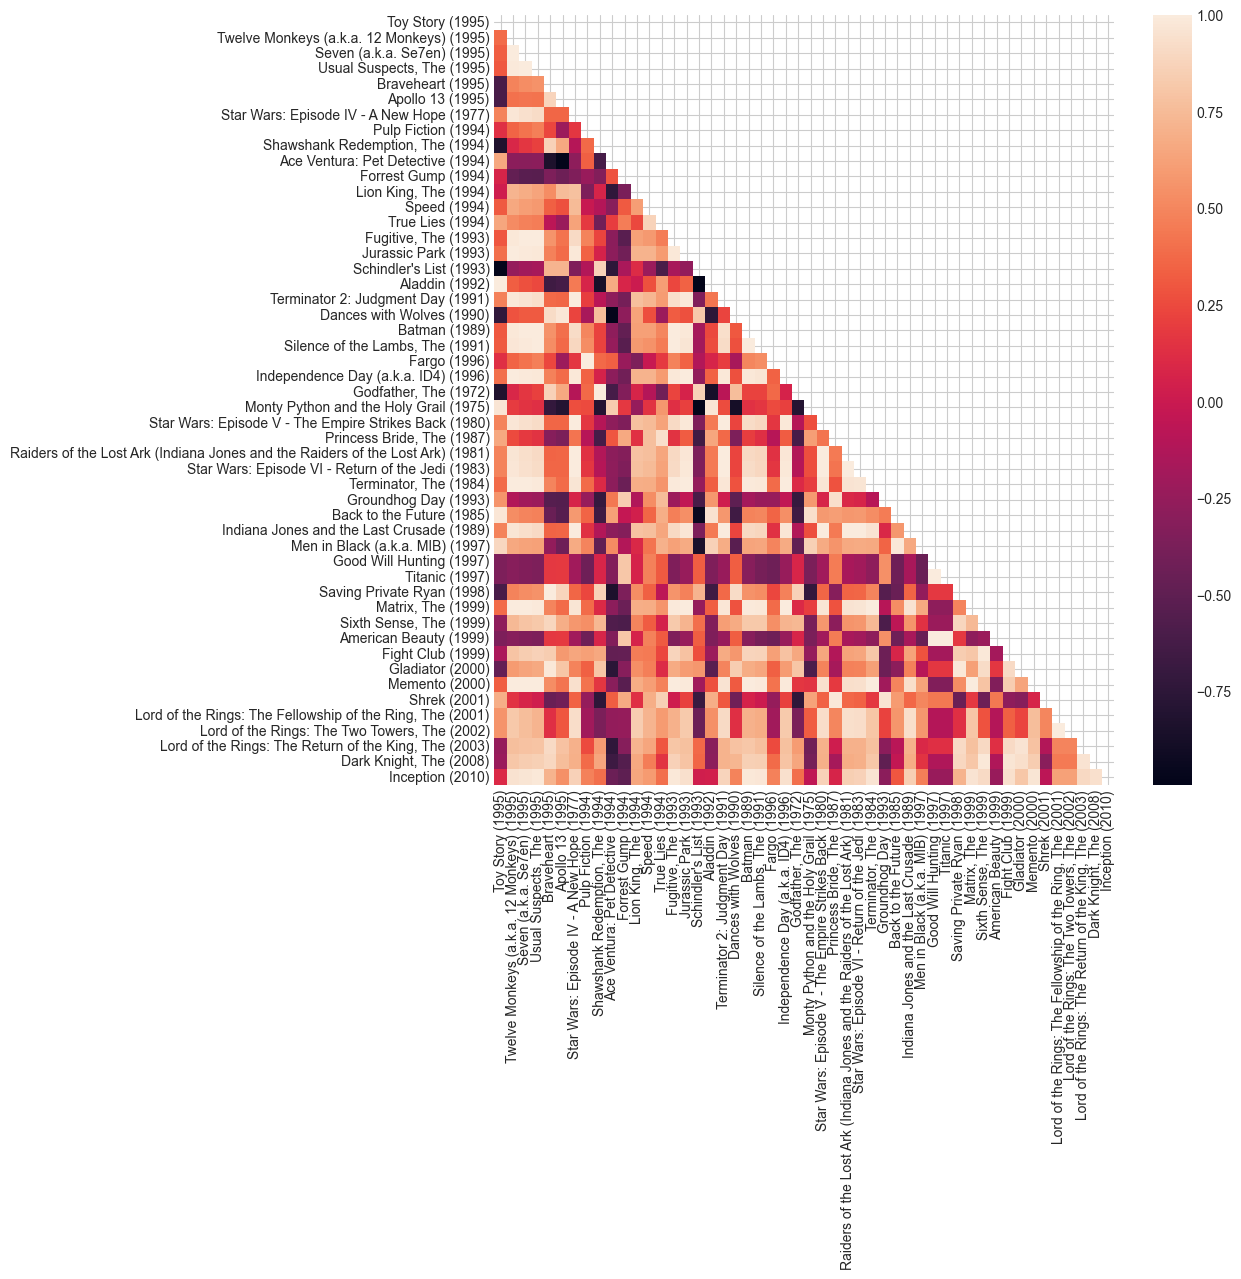

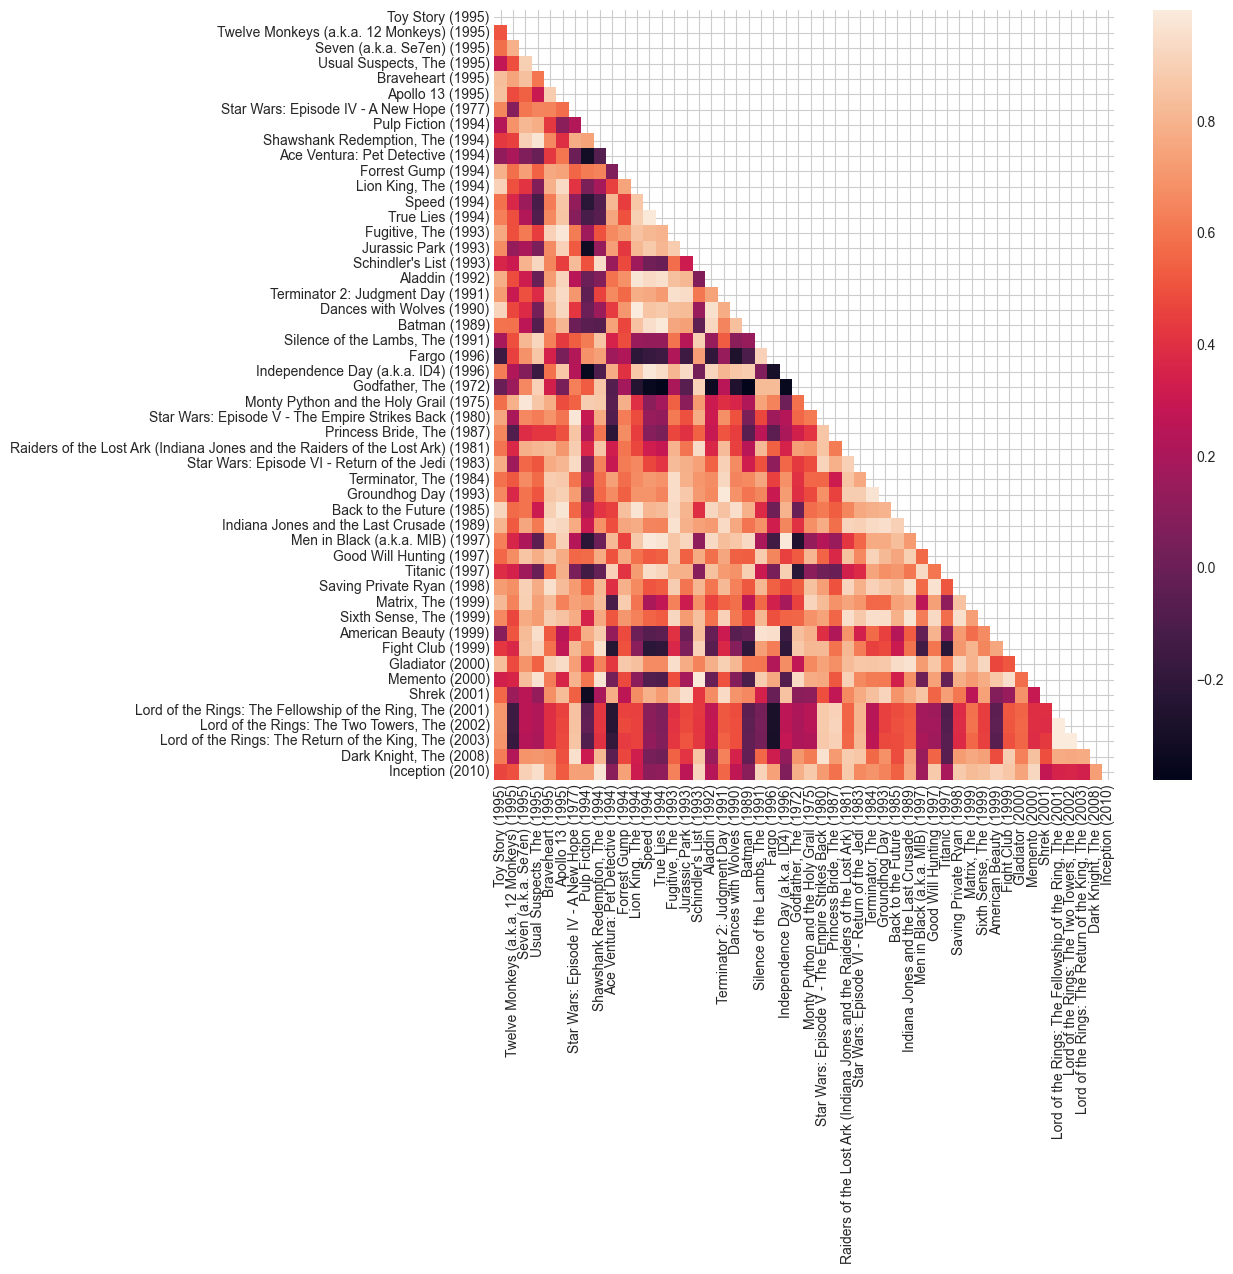

In [6]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)

    utilities.plot_similarities(similarity_matrix=similarity_matrix, labels=labels)

### T-SNE clusters

In [7]:
import plotly.express as px
from sklearn.manifold import TSNE


def plot_tsne_scatter(movie_embeddings_df):
    tsne_df = top_movies_df["movieId", "title"].join(
        movie_embeddings_df, on="movieId", how="left"
    )

    embedding_vectors = tsne_df.drop(["movieId", "title"]).to_numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embedding_vectors)
    tsne_df = tsne_df.with_columns(
        tsne_embeddings_0=tsne_embeddings[:, 0], tsne_embeddings_1=tsne_embeddings[:, 1]
    )

    fig = px.scatter(
        tsne_df.to_pandas(),
        x="tsne_embeddings_0",
        y="tsne_embeddings_1",
        hover_data=["title"],
        height=800,
        width=1000,
        template="seaborn",
        text="title",
        title="Embedding TSNE",
    )
    fig.show()


# plot_tsne_scatter(movie_embeddings_dfs['tf_idf'])
plot_tsne_scatter(movie_embeddings_dfs["nn"])